# Fraud Detection using Amazon SageMaker built-in XGBoost - Supervised Learning

## Introduction

In many real life situations, you will encounter where you do not have labeled data and still you need to detect fraudaulent activites. This technique walks you through how to learn features, build a model using unlabeled dataset and helps you to detect frauds.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

The dataset location is on Amazon S3: https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip 

## Investigate and process the data

Let's start by downloading and reading in the credit card fraud data set.

In [1]:
!wget -P data/ -N https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
    
import zipfile
with zipfile.ZipFile("data/creditcardfraud.zip", 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall("data")


--2020-12-22 06:06:03--  https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.229.176
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.229.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘data/creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  10.9MB/s    in 6.8s    

2020-12-22 06:06:11 (9.68 MB/s) - ‘data/creditcardfraud.zip’ saved [69155632/69155632]

Unzipping...


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./data/creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [3]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()
data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [4]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here:. 

Tip: For our dataset this amount of preprocessing will give us reasonable accuracy, but it's important to note that there are more preprocessing steps one can use to improve accuracy . For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

In [5]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Let's do some analysis and discuss different ways we can preprocess our data. Let's discuss the way in which this data was preprocessed.

## SageMaker XGB

### Prepare Data and Upload to S3

The Amazon common libraries provide utilities to convert NumPy n-dimensional arrays into a the Record-IO format which SageMaker uses for a concise representation of features and labels. The Record-IO format is implemented via protocol buffer so the serialization is very efficient.

In [6]:
model_data = data
model_data.head()
model_data = pd.concat([model_data['Class'], model_data.drop(['Class'], axis=1)], axis=1)
model_data.head()


,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Now we upload the data to S3 using boto3.

In [9]:
import boto3
import os
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
sagemaker_iam_role = sagemaker.get_execution_role()

boto_session = boto3.Session()
region = boto_session.region_name

prefix = 'sagemaker/DEMO-xgboost-fraud'

Prepare training, validation and test data.

In [10]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


boto_session.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto_session.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')
s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-ap-southeast-2-593380422482/sagemaker/DEMO-xgboost-fraud/train/train.csv
Uploaded training data location: s3://sagemaker-ap-southeast-2-593380422482/sagemaker/DEMO-xgboost-fraud/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-ap-southeast-2-593380422482/sagemaker/DEMO-xgboost-fraud/output


---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.
To specify the Linear Learner algorithm, we use a utility function to obtain it's URI. A complete list of build-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [12]:
container = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.2-1")

Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [14]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

SageMaker abstracts training with Estimators. We can pass container, and all parameters to the estimator, as well as the hyperparameters for the linear learner and fit the estimator to the data in S3.
Note: For IP protection reasons, SageMaker built-in algorithms, such as XGBoost, can't be run locally, i.e. on the same instance where this Jupyter Notebook code is running. 

In [22]:
xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker_iam_role, 
                                    instance_count = 1, 
                                    instance_type = 'ml.m5.xlarge',
                                    output_path = output_location,
                                    sagemaker_session = session,
                                    max_run = 20 * 60,
                                    use_spot_instances = True,
                                    max_wait = 20 * 60) # wait for 300s on managed spot training, if fails, use on-demand
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

In [23]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2020-12-22 06:46:09 Starting - Starting the training job...
2020-12-22 06:46:10 Starting - Launching requested ML instancesProfilerReport-1608619568: InProgress
......
2020-12-22 06:47:22 Starting - Preparing the instances for training......
2020-12-22 06:48:34 Downloading - Downloading input data...
2020-12-22 06:49:04 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
INFO:ro

### Host XGBoost Model

Now we deploy the estimator to and endpoint.

In [24]:
xgb.name = 'deployed-xgboost-fraud-prediction'
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m5.xlarge',
                          endpoint_name='deployed-xgboost-fraud-prediction')

-------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, 
simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [27]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [47]:
test_data

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
156699,0,108720.0,1.766913,0.251711,-0.501575,4.214333,0.152405,-0.054836,0.066733,-0.142544,...,-0.269055,-0.045084,0.070225,0.031831,-0.117100,0.049678,0.056044,-0.075564,-0.046625,84.22
189453,0,128407.0,0.244865,-2.935385,-2.641925,1.212391,-0.927223,-0.887115,1.258957,-0.441144,...,1.611841,0.298892,-0.996756,-0.611389,-0.179716,-0.440728,-0.175587,-0.183370,0.135004,926.67
171632,0,120743.0,-1.845167,1.067365,-0.305292,0.477415,2.378210,-0.308770,1.345665,-0.432156,...,-0.294273,-0.180982,-0.028561,-0.967699,0.135233,1.180916,-0.367559,-0.451136,0.062387,44.12
271641,0,164670.0,2.008275,-0.562768,-0.591703,0.380489,-0.591979,-0.215331,-0.699080,0.054018,...,-0.262080,0.190666,0.736771,-0.003363,-0.716620,0.004677,-0.106274,0.030152,-0.046083,19.95
97357,0,66183.0,0.678375,-1.426937,0.669737,0.229416,-1.267753,0.621544,-0.697380,0.447915,...,0.236969,-0.059631,-0.590134,-0.124976,-0.281126,-0.100933,0.957737,-0.084522,0.034037,250.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109950,0,71613.0,1.324629,-0.181641,0.112098,-0.443294,-0.259921,-0.058018,-0.413213,0.119846,...,-0.090432,-0.172716,-0.565828,-0.044942,-0.805622,0.206340,0.963207,-0.083072,-0.015200,0.75
257557,0,158224.0,-0.761115,0.752660,-0.588619,-0.735394,1.047455,-0.687428,1.506912,-0.430123,...,-0.467518,0.174627,0.730944,-0.031881,-0.358848,-0.429493,-0.423124,-0.276905,0.242209,49.99
185893,0,126867.0,0.046435,0.778347,0.271485,-0.571705,0.285194,-1.161162,0.923525,-0.134226,...,-0.125217,-0.275709,-0.676042,0.083668,0.003889,-0.534995,0.142126,0.239108,0.094581,2.28
68710,0,53109.0,0.601423,0.531141,0.589295,0.888435,-0.432970,-0.320487,0.119739,-0.076921,...,-0.130512,-0.092272,-0.052984,0.437723,0.431241,-1.139842,0.036512,-0.282478,-0.132820,12.95


In [ ]:
def predict(xgb_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        result = xgb_predictor.predict(array)
        predictions = ','.join([predictions, ','.join(result[0])])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(xgb_predictor, test_data.values[:, 1:])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values. In this case, we're simply predicting whether the customer churned (1) or not (0), which produces a simple confusion matrix.

In [46]:
test_nonfrauds, test_frauds = test_data.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  54
Number of non-frauds:  28427
Percentage of fradulent data: 0.1896000842667041


In [48]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,28426,1
1,12,42


In [ ]:
#precision: tp / (tp + fp)
#recall: tp / (tp + fn)
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.round(predictions))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

Note, due to randomized elements of the algorithm, you results may differ slightly.

Of the 54 fraudsters, we've correctly predicted 40 of them (true positives). And, we incorrectly predicted 1 case of fraud (false positive). There are also 14 cases of fraud that the model classified as benign transaction (false negatives) - which can get really expensive.

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. So, we should consider adjusting this cutoff. That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

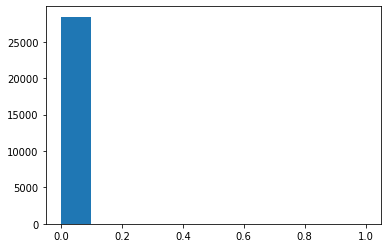

In [50]:
plt.hist(predictions)
plt.show()

By varying the cutoff threshold, we can trade false positives for false negatives. 

In [51]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.04, 1, 0))

col_0,0,1
Class,,
0,28412,15
1,8,46


In [53]:
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.where(predictions > 0.04, 1, 0))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

precision:  0.75
recall:  0.85


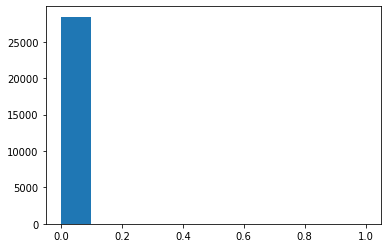

In [54]:
plt.hist(predictions)
plt.show()

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. 
If we put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. Because the choice of the cutoff affects all four of these statistics, we need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem fraud detection? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the cost of \$0.00 to both the true negatives (correctly recognized benign transactions) and true positives (correctly recognized fraudulent transactions). Our model essentially correctly identified both situations. One can assign a benefit (i.e. negative cost) to correctly detected fraud, but we are not going to do this here.

False negatives are the most problematic, because they represent a fraudulent transactions that slipped through our model. Based on some Internet research (see sources below), we assign a cost of \$450.00 for each one. This is the cost of false negatives.

Finally, False positives are the genuine transactions that our model would block as fraud. This would result in an annoyed customer that might possibly close the credit card account and move to another bank. We assume that it costs a \$500.00 sign-on bonus to obtain a cr. card customer and that \5 percent of annoyed customers would defect. 

Source:

https://www.creditcards.com/credit-card-news/credit-card-security-id-theft-fraud-statistics-1276.php
https://wallethub.com/edu/cc/credit-debit-card-fraud-statistics/25725/


#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. We should be minimizing a cost function that looks like this:

```txt
$450 * FN(C) + $0 * TN(C) + 0.05*$500 * FP(C) + $0 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

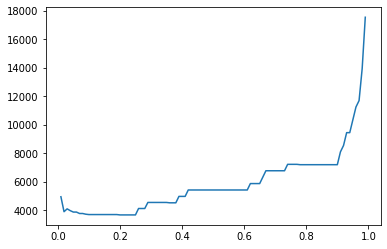

Cost is minimized near a cutoff of: 0.2


In [55]:
TN_cost = 0
TP_cost = 0
FP_cost = 0.05*500 #$cost of losing an annoyed customer (assuming 5% defection and $500 sign-on bonus)
FN_cost = 450 # $cost of of letting a fradulent transaction slip through

cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[TN_cost, FP_cost], [FN_cost, TP_cost]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)])

---

## [Optional] Hyperparameter Optimization (HPO)
*Note, with the default settings below, the hyperparameter tuning job can take up to 20~30 minutes to complete.*

We will use SageMaker HyperParameter Optimization (HPO) to automate the searching process effectively. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.

SageMaker hyperparameter tuning will automatically launch **multiple training jobs** with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will specify the maximum number of HPO tries (`max_jobs`) and how many of these can happen in parallel (`max_parallel_jobs`).

Tip: `max_parallel_jobs` creates a **trade-off between performance and speed** (better hyperparameter values vs how long it takes to find these values). If `max_parallel_jobs` is large, then HPO is faster, but the discovered values may not be optimal. Smaller `max_parallel_jobs` will increase the chance of finding optimal values, but HPO will take more time to finish.

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: **validation:auc** and **train:auc**, and we elected to monitor *validation:auc* as you can see below. In this case (because it's pre-built for us), we only need to specify the metric name.

For more information on the documentation of the Sagemaker HPO please refer [here](https://sagemaker.readthedocs.io/en/stable/tuner.html).

In [56]:
# import required HPO objects
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# set up hyperparameter ranges
ranges = {
    "num_round": IntegerParameter(1, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator = xgb,              # the SageMaker estimator object
    hyperparameter_ranges=ranges,     # the range of hyperparameters
    max_jobs = 12,                      # total number of HPO jobs
    max_parallel_jobs = 3,              # how many HPO jobs can run in parallel
    strategy="Bayesian",              # the internal optimization strategy of HPO
    objective_metric_name = objective,  # the objective metric to be used for HPO
    objective_type = "Maximize",        # maximize or minimize the objective metric
)  


### Launch HPO
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [ ]:
# start HPO
tuner.fit({ "train": s3_input_train, "validation": s3_input_validation })

..................................................

HPO jobs often take quite a long time to finish and as such, sometimes you may want to free up the notebook and then resume the wait later.

Just like the Estimator, we won't be able to `deploy()` the model until the HPO tuning job is complete; and the status is visible through both the [AWS Console](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) and the [SageMaker API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html). We could for example write a polling script like the below:

In [ ]:
# wait, until HPO is finished
hpo_state = None

while hpo_state is None or hpo_state == "InProgress":
    if hpo_state is not None:
        print("-", end="")
        time.sleep(60)  # Poll once every 1 min
    hpo_state = sgmk_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name,
    )["HyperParameterTuningJobStatus"]

print("\nHPO state:", hpo_state)


In [ ]:
### Deploy and test optimized model
Deploying the best model is another simple `.deploy()` call:

In [ ]:
# deploy the best model from HPO
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)


In [ ]:
predictions = predict(hpo_predictor, test_data.values[:, 1:])
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

## Clean up

We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run `xgb_predictor.delete_endpoint()`

In [49]:
#xgb_predictor.delete_endpoint()


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing